In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/
%cd cs231n/
%cd neural_style_transfer

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/cs231n
/content/drive/My Drive/cs231n/neural_style_transfer


# A NEURAL ALGORITHM OF ARTISTIC STYLE

## Implementing basic neural style transfer from scratch
###Link to original paper: [A Neural Algorithm of Artistic Style: Leon A. Gatys, Alexander S. Ecker, Matthias Bethge (2015)](https://arxiv.org/abs/1508.06576)


### Neural Style Transfer is a deep learning method to compose images in the style of another image. It is basically an optimization technique which takes three images: a content image, a style reference image (such as an artwork by a famous painter), and the input image we want to style — and it blend thems together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

####Example of Stanford Campus Image rendered in the style of 'Starry Night' by Vincent Van Gogh (1889)

![Example of Stanford Campus Image rendered in the style of 'Starry Night' by Vincent Van Gogh' (1889)](https://cdn-images-1.medium.com/max/1650/1*XsXMU-MwGH_O3Trt6OKhuw.png)

In [2]:
from __future__ import print_function
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


##Loading content image and style image and displaying both

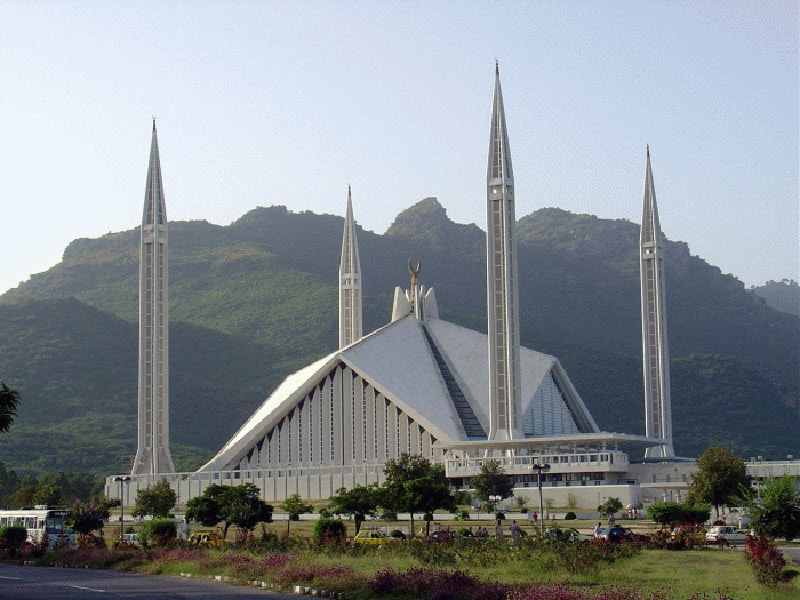

In [3]:
height = 600  
width = 800
content_image_path = 'content.png'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width,height)) # resize images into dimensions 800x600. Any arbitrary dimensions can be used.
content_image

###The Faisal Mosque in Islamabad, Pakistan.

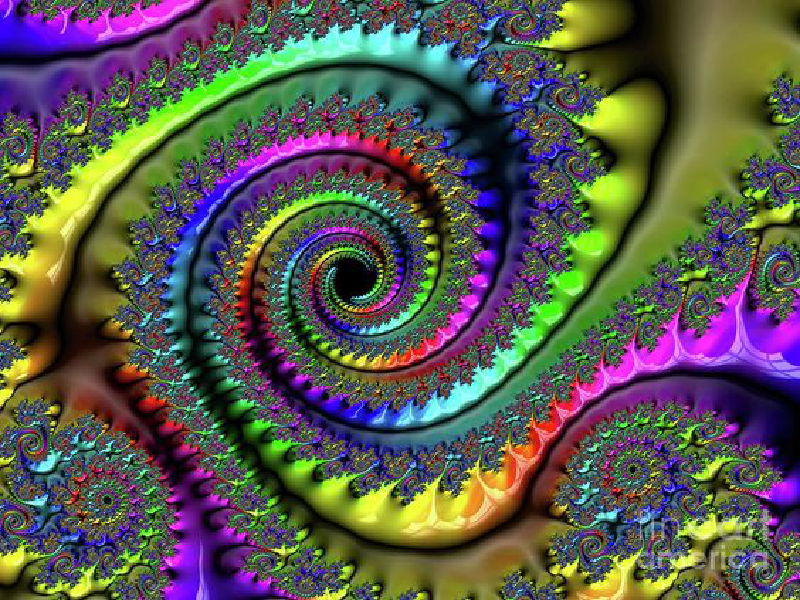

In [4]:
style_image_path = 'style.png'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

### Fractal Rainbow Swirls is a piece of digital artwork by Elisabeth Lucas

##Casting images into numpy arrays & reshaping and normalizing them

In [5]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 600, 800, 3)
(1, 600, 800, 3)


In [0]:
#The mean to subtract from the all 3 channels of the input to the VGG model. 
#This is the mean that was obtained when the VGG was trained. 
#Helps in optimizing model performance.

content_array[:, :, :, 0] -= 103.939 
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

##Prepare tensor over which we will backpropagate over in VGG network

In [0]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1,height,width,3))
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [8]:
print(input_tensor)


Tensor("concat:0", shape=(3, 600, 800, 3), dtype=float32)


In [9]:
model = VGG16(input_tensor = input_tensor,weights = 'imagenet',include_top = False)


58892288/58889256 [==============================] - 2s 0us/step


## Set Alpha (content weight) & Beta (style weight) parameters.

In [10]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 600, 800, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 600, 800, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 300, 400, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 300, 400, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 300, 400, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 150, 200, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 150, 200, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 150, 200, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 150, 200, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 75, 100, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 75, 100, 512) dtype=float32>,
 

##Define gram matrix and content+style loss functions

In [11]:
loss = backend.variable(0)

def content_loss(content , combination):
    return backend.sum(backend.square(combination-content))
  

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)


def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(features,backend.transpose(features))
    return gram

def style_loss(style,combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height*width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_features,combination_features)
    loss += (style_weight / len(feature_layers)) * sl


def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)


grads = backend.gradients(loss, combination_image)

##Functions for evaluating loss and gradient

In [0]:
outputs = [loss]
outputs +=grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

##Iterate 10 times and use L-BFGS to minimize our loss functions (can also use Adam's GD here to conserve memory )

In [13]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 225962330000.0
Iteration 0 completed in 40s
Start of iteration 1
Current loss value: 142180710000.0
Iteration 1 completed in 28s
Start of iteration 2
Current loss value: 116601590000.0
Iteration 2 completed in 28s
Start of iteration 3
Current loss value: 106971330000.0
Iteration 3 completed in 28s
Start of iteration 4
Current loss value: 102159830000.0
Iteration 4 completed in 28s
Start of iteration 5
Current loss value: 99512990000.0
Iteration 5 completed in 28s
Start of iteration 6
Current loss value: 97686900000.0
Iteration 6 completed in 28s
Start of iteration 7
Current loss value: 96507310000.0
Iteration 7 completed in 28s
Start of iteration 8
Current loss value: 95678260000.0
Iteration 8 completed in 28s
Start of iteration 9
Current loss value: 95038930000.0
Iteration 9 completed in 28s


##Reshape, normalize and spit out our generated image that has content of content_image and style of style_image 

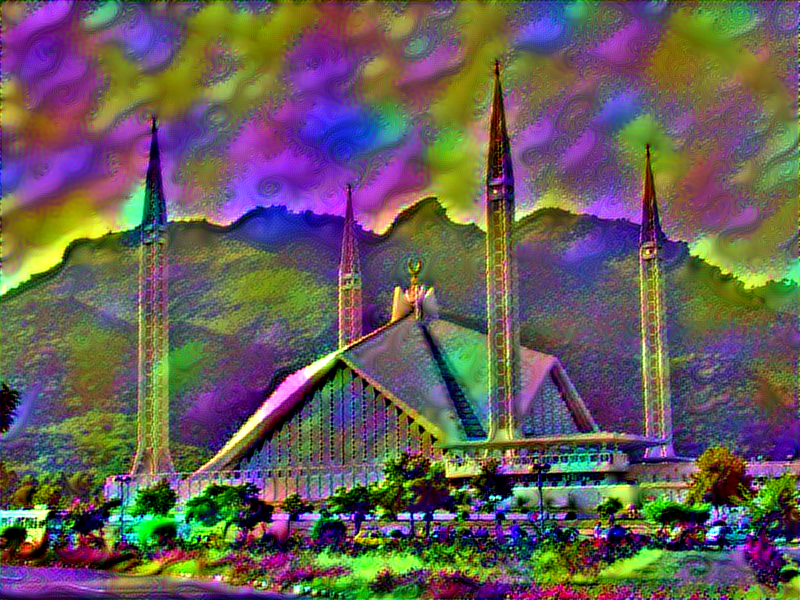

In [14]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

###The Faisal Mosque rendered in the style of the Fractal rainbows artwork.